1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


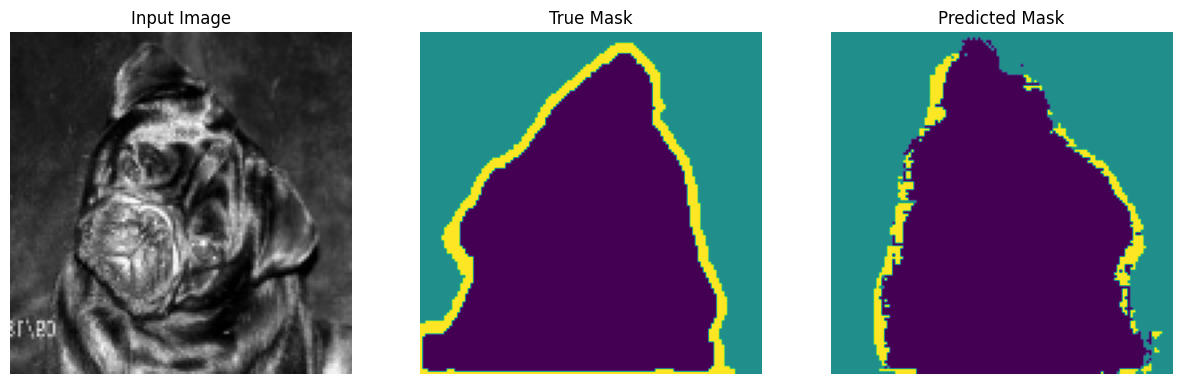


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8019 - loss: 0.4860 - val_accuracy: 0.8597 - val_loss: 0.3829


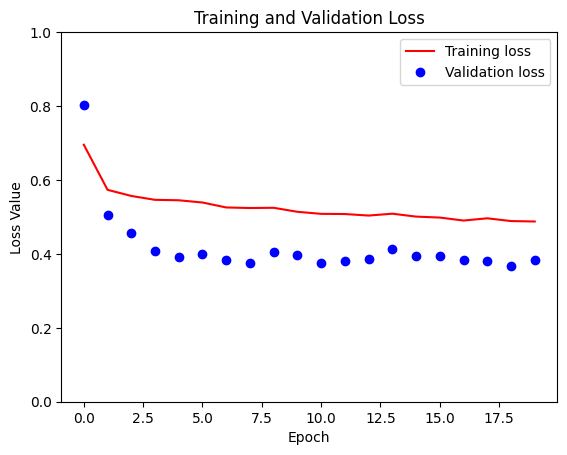

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


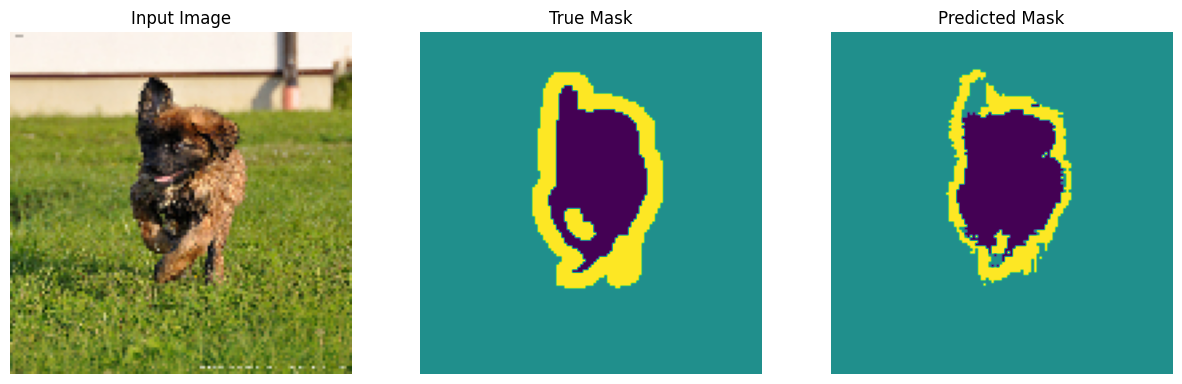

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


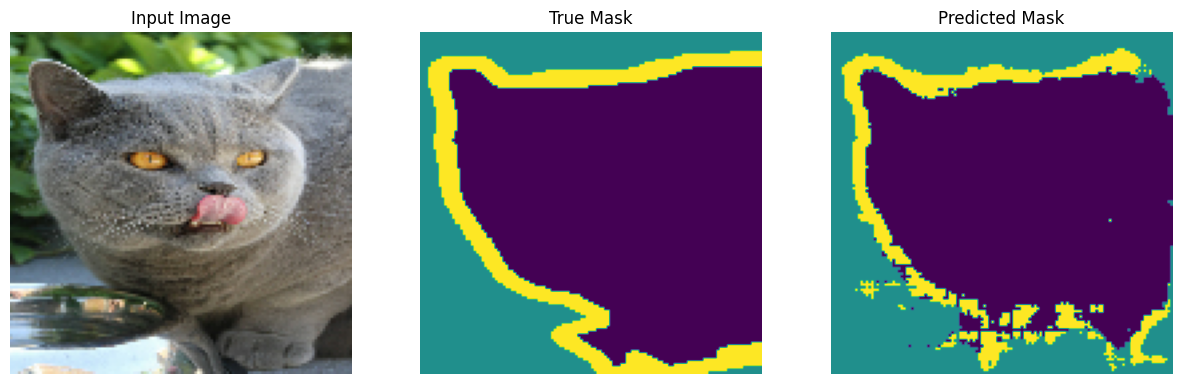

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


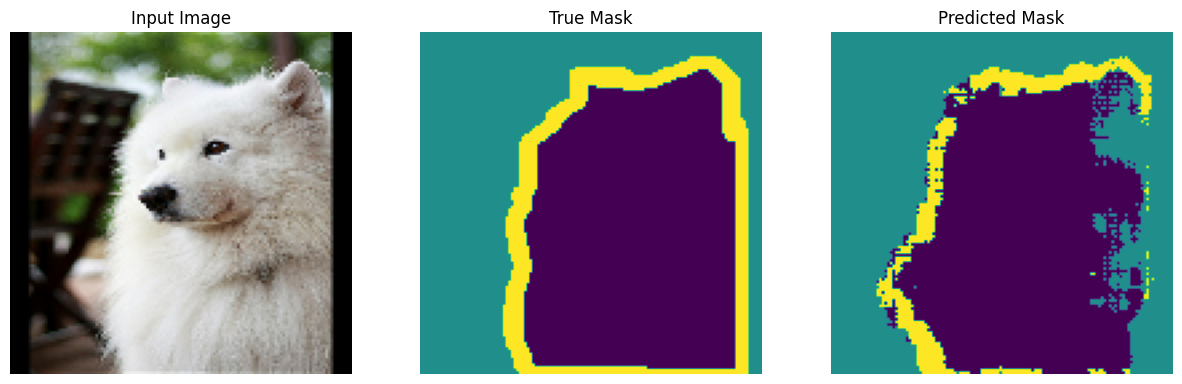

In [2]:
import sys
sys.path.append('C:\\Users\\caudillo\\examples')

import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
from vit_keras import vit, utils


# Cargando dataset oxford_iiit_pet
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

# Normalizar colores
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (128, 128),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

# The dataset already contains the required training and test splits, so continue to use the same splits
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Build the input pipeline
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)



In [ ]:
# Define the ViT model
def vit_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Use the ViT model from vit_keras library
    model = vit.vit_b16(
        image_size=128,
        activation='softmax',
        pretrained=False,
        include_top=False,
        pretrained_top=False
    )
    
    # Adapt the output of the ViT model to match the output channels
    x = model(inputs)
    x = tf.keras.layers.Conv2D(output_channels, kernel_size=1, padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Train the model
OUTPUT_CLASSES = 3

model = vit_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()




In [ ]:
# Callback for visualization
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])



In [ ]:
# Plot the training history
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()



In [ ]:
# Make predictions
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(test_batches, 3)